# Feature Generator 

데이터 EDA를 기반으로 새로운 feature을 생성하겠습니다.  
순서는 다음과 같습니다. 
1. 변수 생성: `누적 행동 데이터`
2. 변수 생성: `weekday`, `holiday`
3. 변수 생성: `hour`
4. 변수 생성: `latest`
5. 변수 생성: `prefer_dvc_trfc`
6. 외부데이터: `온도`, `습도`, `강수량`, `강수형태`
<br><br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import warnings
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tq
pd.set_option('display.max_row',300)
%matplotlib inline
warnings.filterwarnings(action='ignore')

## load data

In [5]:
cks_dtype = {'clnt_id':'int64','sess_id':'int64','hit_seq':'int64','action_type':'int64','biz_unit':'category','sess_dt':'object','hit_tm':'object',
             'hit_pss_tm':'int64','trans_id':'float64','sech_kwd':'object','tot_pag_view_ct':'float64','tot_sess_hr_v':'float64','trfc_src':'category',
             'dvc_ctg_nm':'object','pd_c':'object','de_dt':'object','de_tm':'object','buy_am':'int64','buy_ct':'int64','clnt_gender':'category'}

online = pd.read_csv('./data/online_03.csv', dtype=cks_dtype)
trade = pd.read_csv('./data/trade_01.csv', dtype=cks_dtype)
customer = pd.read_csv('./data/customer_01.csv', dtype=cks_dtype)
item = pd.read_csv('./data/item_01.csv', dtype=cks_dtype)

In [3]:
df1_online = online.copy()

<br>

### 1. 변수 생성: `누적 행동 데이터`
- action_type을 활용하여 누적 행동 정보를 생성하겠습니다. 
- 누적 행동 정보는 고객의 과거 행동 추이를 확인 할 수 있습니다. 

In [17]:
df1_dummy = pd.get_dummies(df1_online['action_type'], prefix='cum_act', prefix_sep='_')
df1_online = pd.concat([df1_online, df1_dummy], axis=1)

In [18]:
# 각 행동 유형별로 누적해서 합해주는 함수.
for i in range(7):
    col = 'cum_act_'+str(i)
    df1_online[col] = df1_online.groupby(['clnt_id', 'sess_id'])[col].cumsum() 
    ## 수정

In [24]:
df1_online.head(2122215).tail(10)

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,trfc_src,dvc_ctg_nm,cum_act_0,cum_act_1,cum_act_2,cum_act_3,cum_act_4,cum_act_5,cum_act_6,cum_act_7
2122205,41286,97,42,0,A03,20190826,10:34,2383307,NaN,빈대떡,...,PUSH,mobile_app,13,8,9,9,0,3,0,0
2122206,41286,97,43,2,A03,20190826,10:34,2387041,NaN,NaN,...,PUSH,mobile_app,13,8,10,9,0,3,0,0
2122207,41286,97,44,5,A03,20190826,10:34,2390864,NaN,NaN,...,PUSH,mobile_app,13,8,10,9,0,4,0,0
2122208,41286,98,1,2,A03,20190826,14:39,12156,NaN,NaN,...,PUSH,mobile_app,0,0,1,0,0,0,0,0
2122209,41286,98,2,3,A03,20190826,14:39,17086,NaN,NaN,...,PUSH,mobile_app,0,0,1,1,0,0,0,0
2122210,41286,98,3,3,A03,20190826,14:40,52046,NaN,NaN,...,PUSH,mobile_app,0,0,1,2,0,0,0,0
2122211,41286,98,4,5,A03,20190826,14:40,55222,NaN,NaN,...,PUSH,mobile_app,0,0,1,2,0,1,0,0
2122212,41286,98,5,4,A03,20190826,14:40,86026,NaN,NaN,...,PUSH,mobile_app,0,0,1,2,1,1,0,0
2122213,41286,98,6,5,A03,20190826,14:40,87182,NaN,NaN,...,PUSH,mobile_app,0,0,1,2,1,2,0,0
2122214,41286,98,7,4,A03,20190826,14:40,106091,NaN,NaN,...,PUSH,mobile_app,0,0,1,2,2,2,0,0


In [20]:
df1_online.to_csv('./data/online_04-1.csv',index=False)

In [4]:
df1_online = pd.read_csv('./data/online_04-1.csv')

<br>

### 2. 변수 생성: `weekday`, `holiday`
- 날짜 데이터를 활용하여 `weekday` 요일을 생성하겠습니다. 
- `0:월 / 1:화 / 2:수 / 3:목 / 4:금 / 5:토 / 6:일` 로 맵핑됩니다.
<br>

- 주말, 광복절, 추석은 `holiday`로 생성합니다. 
- (예) '2019-08-15'-광복절, '2019-09-12'-추석연휴,'2019-09-13'-추석연휴
    - 주말과 공휴일은 1, 그 외 요일은 0이 됩니다. 
    - hit_seq 1\~4에는 buy_id가 1, hit_seq 5\~10에 buy_id가 2가 됩니다.

In [22]:
# 공휴일 list
holist = ['2019-08-15','2019-09-12','2019-09-13'] 
# sess_dt col의 자료형 변경
df1_online.sess_dt = pd.to_datetime(df1_online.sess_dt, format='%Y%m%d') 
# 요일숫자(0-월, 1-화) (=dayofweek)
df1_online['day'] = df1_online['sess_dt'].dt.weekday 
df1_online['holiday'] = df1_online['day'].apply(lambda x: (x==5)|(x==6)).astype(np.int64)
df1_online['holiday'] = df1_online['holiday'] + df1_online['sess_dt'].apply(lambda x: x.strftime('%Y-%m-%d') in holist)
df1_online.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,cum_act_0,cum_act_1,cum_act_2,cum_act_3,cum_act_4,cum_act_5,cum_act_6,cum_act_7,day,holiday
0,1,1,1,0,A01,2019-09-11,16:14,11880,NaN,과일선물세트,...,1,0,0,0,0,0,0,0,2,0
1,1,1,2,0,A01,2019-09-11,16:15,22432,NaN,과일선물세트 백화점,...,2,0,0,0,0,0,0,0,2,0
2,1,1,3,0,A01,2019-09-11,16:15,36140,NaN,과일바구니,...,3,0,0,0,0,0,0,0,2,0
3,1,2,1,0,A01,2019-09-22,14:09,41584,NaN,초등가을잠바,...,1,0,0,0,0,0,0,0,6,1
4,1,2,2,0,A01,2019-09-22,14:10,56113,NaN,초등가을점퍼,...,2,0,0,0,0,0,0,0,6,1


In [23]:
df1_online.to_csv('./data/online_04-2.csv',index=False)

In [24]:
df1_online = pd.read_csv('./data/online_04-2.csv')

<br>

### 3. 변수 생성: `hour`
- `hit_tm`을 시간대별 분류를 통해 카테고리화하였습니다.
- (예) 23:35 -> 23, 23:47 -> 23

In [25]:
df1_online['hour'] = df1_online['hit_tm'].apply(lambda x: np.int8(x[:2]))
df1_online.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,cum_act_1,cum_act_2,cum_act_3,cum_act_4,cum_act_5,cum_act_6,cum_act_7,day,holiday,hour
0,1,1,1,0,A01,2019-09-11,16:14,11880,NaN,과일선물세트,...,0,0,0,0,0,0,0,2,0,16
1,1,1,2,0,A01,2019-09-11,16:15,22432,NaN,과일선물세트 백화점,...,0,0,0,0,0,0,0,2,0,16
2,1,1,3,0,A01,2019-09-11,16:15,36140,NaN,과일바구니,...,0,0,0,0,0,0,0,2,0,16
3,1,2,1,0,A01,2019-09-22,14:09,41584,NaN,초등가을잠바,...,0,0,0,0,0,0,0,6,1,14
4,1,2,2,0,A01,2019-09-22,14:10,56113,NaN,초등가을점퍼,...,0,0,0,0,0,0,0,6,1,14


In [26]:
df1_online.to_csv('./data/online_04-3.csv',index=False)

In [3]:
df1_online = pd.read_csv('./data/online_04-3.csv')

<br>

### 4. 변수 생성: `latest`

##### `latest_pv_hr`
- `pv_hr`은 온라인행동데이터의 `세션내총페이지뷰수/세션내총시간`으로 단위 페이지당 머무른 시간을 나타내는 서핑속도입니다.
- `latest_pv_hr_1`: 가장 최근 구매가 발생한 과거의 세션의 pv_hr입니다.
- `latest_pv_hr_3`: 세번째로 오래된 구매가 발생한 세션의 pv_hr입니다.

In [4]:
# tot_sess가 0인 경우 나누면 inf가 되기 때문에 1로 변경
df1_online.loc[df1_online['tot_sess_hr_v'] == 0, 'tot_sess_hr_v'] = 1

In [5]:
# clnt_id와 sess_id 별로 단위 페이지당 머무른 시간을 계산. 
df1_online['pv_hr'] = df1_online['tot_pag_view_ct'] /  df1_online['tot_sess_hr_v']
temp = df1_online[['clnt_id', 'sess_id', 'tot_pag_view_ct', 'tot_sess_hr_v', 'pv_hr']]
df_pv_hr = temp.groupby(['clnt_id', 'sess_id'], as_index = False).first().reset_index(drop = True)
df_pv_hr.head()

,clnt_id,sess_id,tot_pag_view_ct,tot_sess_hr_v,pv_hr
0,1,1,14.0,124.0,0.112903
1,1,2,45.0,424.0,0.106132
2,2,1,61.0,911.0,0.066959
3,2,2,12.0,134.0,0.089552
4,2,3,12.0,942.0,0.012739


In [6]:
df1_online = df1_online.merge(df_pv_hr, how = 'left')

In [7]:
# 최근 머무른 시간을 담기 위한 column을 추가.
df1_online['latest_pv_hr_1'] = 0
df1_online['latest_pv_hr_2'] = 0
df1_online['latest_pv_hr_3'] = 0
df1_online.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,cum_act_5,cum_act_6,cum_act_7,day,holiday,hour,pv_hr,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3
0,1,1,1,0,A01,2019-09-11,16:14,11880,NaN,과일선물세트,...,0,0,0,2,0,16,0.112903,0,0,0
1,1,1,2,0,A01,2019-09-11,16:15,22432,NaN,과일선물세트 백화점,...,0,0,0,2,0,16,0.112903,0,0,0
2,1,1,3,0,A01,2019-09-11,16:15,36140,NaN,과일바구니,...,0,0,0,2,0,16,0.112903,0,0,0
3,1,2,1,0,A01,2019-09-22,14:09,41584,NaN,초등가을잠바,...,0,0,0,6,1,14,0.106132,0,0,0
4,1,2,2,0,A01,2019-09-22,14:10,56113,NaN,초등가을점퍼,...,0,0,0,6,1,14,0.106132,0,0,0


In [8]:
# 최근 머무른 시간을 추가. 
def latest_pv_hr(df):
    temp_df = df[['sess_id', 'pv_hr']].groupby('sess_id').first()
    for s in df['sess_id'].unique():
        temp = temp_df[temp_df.index < s].tail(3)
        temp_idx = df[df['sess_id'] == s].index
        for i in range(len(temp)):
              df.loc[temp_idx, f'latest_pv_hr_{i+1}'] = temp.iloc[-(i+1), 0]
    return df   

In [9]:
df1_online = df1_online.groupby('clnt_id').apply(lambda x : latest_pv_hr(x))

In [13]:
# null값이 포함되어 있기 때문에 0으로 대체.
df1_online.loc[df1_online['latest_pv_hr_1'].isnull(),'latest_pv_hr_1'] = 0
df1_online.loc[df1_online['latest_pv_hr_2'].isnull(),'latest_pv_hr_2'] = 0
df1_online.loc[df1_online['latest_pv_hr_3'].isnull(),'latest_pv_hr_3'] = 0

##### `latest_act_hr`
- `latest_act_hr`은 온라인행동데이터의 세션 별로 최근에 활동했던 시간 입니다.

In [ ]:
# 최근 활동했던 시간을 담기 위한 column을 추가.
df1_online.loc[df1_online['latest_act_hr_1'].isnull(),'latest_act_hr_1'] = -1
df1_online.loc[df1_online['latest_act_hr_2'].isnull(),'latest_act_hr_2'] = -1
df1_online.loc[df1_online['latest_act_hr_3'].isnull(),'latest_act_hr_3'] = -1

In [106]:
# 최근 활동했던 시간을 추가.
def latest_act_hr(df):
    temp_df = df[['sess_id', 'hour']].groupby('sess_id').first()
    for s in df['sess_id'].unique():
        temp = temp_df[temp_df.index < s].tail(3)
        temp_idx = df[df['sess_id'] == s].index
        for i in range(len(temp)):
              df.loc[temp_idx, f'latest_act_hr_{i+1}'] = temp.iloc[-(i+1), 0]
    return df   

In [107]:
df1_online = df1_online.groupby('clnt_id').apply(lambda x : latest_act_hr(x))

In [114]:
df1_online.head(100).tail(5)

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,holiday,hour,pv_hr,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3,prefer_dvc_trfc,latest_act_hr_1,latest_act_hr_2,latest_act_hr_3
95,23,12,2,0,A01,2019-08-14,21:33,449335,NaN,레이첼콕스 앵클,...,0,21,0.072519,0.070161,0.092527,0.080790,mobile_app_DIRECT,21.0,11.0,13.0
96,23,13,1,0,A01,2019-08-20,20:54,15980,NaN,필라 여성팬티 세트,...,0,20,0.416667,0.072519,0.070161,0.092527,mobile_app_DIRECT,21.0,21.0,11.0
97,23,14,1,0,A01,2019-08-20,23:33,11825,NaN,휠라키즈,...,0,23,0.162602,0.416667,0.072519,0.070161,mobile_app_DIRECT,20.0,21.0,21.0
98,23,14,2,0,A01,2019-08-20,23:34,30525,NaN,휠라키즈 아동화,...,0,23,0.162602,0.416667,0.072519,0.070161,mobile_app_DIRECT,20.0,21.0,21.0
99,23,15,1,0,A01,2019-08-26,13:59,9094,NaN,레이첼콕스,...,0,13,0.060560,0.162602,0.416667,0.072519,mobile_app_DIRECT,23.0,20.0,21.0


In [115]:
df1_online.to_csv('./data/online_04-4.csv',index=False)

In [33]:
df1_online = pd.read_csv('./data/online_04-4.csv')

<br>

### 5. 변수 생성 : `prefer_dvc_trfc`
- 기기와 유입 채널을 하나로 묶어줍니다. 
- (예) mobile_app + DIRECT = mobile_app_DIRECT

In [79]:
# dvc_ctg_nm, trfc_src에 따라 선호하는 유입 유형인 col (prefer_dvc_trfc) 생성
df1_online['prefer_dvc_trfc'] = df1_online['dvc_ctg_nm'].str.cat(df1_online['trfc_src'],sep="_")
df1_online.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,cum_act_6,cum_act_7,day,holiday,hour,pv_hr,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3,prefer_dvc_trfc
0,1,1,1,0,A01,2019-09-11,16:14,11880,NaN,과일선물세트,...,0,0,2,0,16,0.112903,0.000000,0.0,0.0,mobile_app_DIRECT
1,1,1,2,0,A01,2019-09-11,16:15,22432,NaN,과일선물세트 백화점,...,0,0,2,0,16,0.112903,0.000000,0.0,0.0,mobile_app_PUSH
2,1,1,3,0,A01,2019-09-11,16:15,36140,NaN,과일바구니,...,0,0,2,0,16,0.112903,0.000000,0.0,0.0,mobile_app_DIRECT
3,1,2,1,0,A01,2019-09-22,14:09,41584,NaN,초등가을잠바,...,0,0,6,1,14,0.106132,0.112903,0.0,0.0,mobile_app_DIRECT
4,1,2,2,0,A01,2019-09-22,14:10,56113,NaN,초등가을점퍼,...,0,0,6,1,14,0.106132,0.112903,0.0,0.0,mobile_app_DIRECT


In [80]:
df1_online['prefer_dvc_trfc'].value_counts()

mobile_app_DIRECT      1797039
mobile_app_PUSH         458757
mobile_web_DIRECT       314019
mobile_web_PUSH         267935
PC_DIRECT               161054
mobile_web_WEBSITE       38207
PC_WEBSITE               35969
PC_PORTAL_1              31605
PC_PORTAL_2              31465
mobile_web_PORTAL_1      27007
mobile_web_PORTAL_2      16656
mobile_web_PORTAL_3       9112
PC_PORTAL_3               5811
mobile_app_WEBSITE        1640
PC_PUSH                     86
Name: prefer_dvc_trfc, dtype: int64

In [57]:
df1_online.to_csv('./data/online_04-5.csv',index=False)

In [37]:
df1_online = pd.read_csv('./data/online_04-5.csv')

<br>

### 6. 외부데이터: `기온`, `습도`, `강수형태`, `강수량`
- 기상청 데이터를 활용하여 7월-9월의 데이터를 추가하겠습니다. 
- 습도, 기온, 강수형태, 강수량 feature을 생성합니다. 

In [43]:
# 외부 데이터 파일 load
TEMP = pd.read_csv('./data/기온_201907_201909.csv')
HUM = pd.read_csv('./data/습도_201907_201909.csv')
PTY = pd.read_csv('./data/강수형태_201907_201909.csv')
R06 = pd.read_csv('./data/강수량_201907_201909.csv')

In [44]:
# column명 변경
HUM.columns = ['sess_dt', 'hour','hum']
TEMP.columns =  ['sess_dt', 'hour','temp']
PTY.columns =  ['sess_dt', 'hour','pty']
R06.columns =  ['sess_dt', 'hour','r06']

In [45]:
# 월별로 나누기 위해서 각 월이 시작하는 index를 불러옴.
index_08 = HUM[HUM['sess_dt'] == ' Start : 20190801 '].index
index_09 = HUM[HUM['sess_dt'] == ' Start : 20190901 '].index

print('start 08 index:', index_08)
print('start 09 index:', index_09)

start 08 index: Int64Index([744], dtype='int64')
start 09 index: Int64Index([1489], dtype='int64')


In [46]:
# 경계 index를 기준으로 7, 8, 9월로 나눔
from functools import reduce
dfs_07 = [HUM[:744], TEMP[:744], PTY[:744], R06[:744]]
dfs_08 = [HUM[744:1489], TEMP[744:1489], PTY[744:1489], R06[744:1489]]
dfs_09 = [HUM[1489:], TEMP[1489:], PTY[1489:], R06[1489:]]

merge_07 = reduce(lambda left, right: pd.merge(left, right, on=['sess_dt', 'hour'], how='left'), dfs_07)
merge_08 = reduce(lambda left, right: pd.merge(left, right, on=['sess_dt', 'hour'], how='left'), dfs_08)
merge_09 = reduce(lambda left, right: pd.merge(left, right, on=['sess_dt', 'hour'], how='left'), dfs_09)

merge_08 = merge_08.drop([0]).reset_index(drop=True)
merge_09 = merge_09.drop([0]).reset_index(drop=True)

In [47]:
# 총 4개의 기상 데이터 merge한 예시
merge_07.head()

,sess_dt,hour,hum,temp,pty,r06
0,1,0.0,59.0,24.700001,0.0,0.0
1,1,100.0,54.0,25.799999,0.0,0.0
2,1,200.0,48.0,26.900000,0.0,0.0
3,1,300.0,44.0,27.500000,0.0,0.0
4,1,400.0,43.0,28.299999,0.0,0.0


In [48]:
# 기상 데이터를 합친 데이터를 online 데이터와 merge하기 위해서 처리
merge_07['sess_dt'] = merge_07['sess_dt'].apply(lambda x: '201907'+x.lstrip().zfill(2))
merge_08['sess_dt'] = merge_08['sess_dt'].apply(lambda x: '201908'+x.lstrip().zfill(2))
merge_09['sess_dt'] = merge_09['sess_dt'].apply(lambda x: '201909'+x.lstrip().zfill(2))

merge_07.sess_dt = pd.to_datetime(merge_07.sess_dt, format='%Y%m%d').astype(str)
merge_08.sess_dt = pd.to_datetime(merge_08.sess_dt, format='%Y%m%d').astype(str)
merge_09.sess_dt = pd.to_datetime(merge_09.sess_dt, format='%Y%m%d').astype(str)

merge_07['hour'] = merge_07['hour'].apply(lambda x: np.int8(x/100))
merge_08['hour'] = merge_08['hour'].apply(lambda x: np.int8(x/100))
merge_09['hour'] = merge_09['hour'].apply(lambda x: np.int8(x/100))

In [49]:
# online 데이터를 월 단위로 분리
df1_online.sort_values(by='sess_dt')
online_07 = df1_online[df1_online['sess_dt'] <= '2019-07-31']
online_08 = df1_online[df1_online['sess_dt'].apply(lambda x: x.startswith('2019-08'))]
online_09 = df1_online[df1_online['sess_dt'] > '2019-08-31']

In [50]:
# online 데이터와 기상 데이터를 월 별로 merge
online_07 = pd.merge(online_07, merge_07, on=['sess_dt', 'hour'], how='left')
online_08 = pd.merge(online_08, merge_08, on=['sess_dt', 'hour'], how='left')
online_09 = pd.merge(online_09, merge_09, on=['sess_dt', 'hour'], how='left')

In [ ]:
# 다시 합쳐줌.
df2_online = pd.concat([online_07, online_08, online_09], ignore_index=True)
df2_online = df2_online.sort_values(by=['clnt_id', 'sess_id']).reset_index(drop=True)

In [ ]:
df2_online.head()

In [ ]:
df2_online.to_csv('./data/online_04-6.csv',index=False)

In [3]:
df2_online = pd.read_csv('./data/online_04-6.csv')

In [234]:
item_add_nm0 = pd.read_csv('./data/item_add_nm0.csv')

In [235]:
item_add_nm0 = pd.read_csv('./data/item_add_nm0.csv')
item_add_nm0 = item_add_nm0[['pd_c', 'clac_nm1']]

In [236]:
item_add_nm0['pd_c'] = item_add_nm0['pd_c'].astype(np.float).astype(str)

In [237]:
df3_trade = trade.merge(item_add_nm0, how = 'left')
df3_trade.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1
0,2,42449.0,1,A02,1015.0,20190704,15:34,46430,1,Men's Clothing
1,2,62037.0,1,A03,92.0,20190729,23:47,36000,20,Beverages
2,2,64691.0,1,A03,186.0,20190731,21:25,3790,1,Chilled Foods
3,2,64691.0,2,A03,151.0,20190731,21:25,3990,1,Canned / Jarred Foods
4,2,64691.0,3,A03,351.0,20190731,21:25,4690,1,Dairy Products


In [238]:
sample_3 = pd.merge(df2_online, 
                     df3_trade, 
                on='trans_id', how='left')

In [239]:
sample_3 = sample_3[sample_3['clac_nm1'].notna()]

In [240]:
sample_3 = sample_3.sort_values('clac_nm1')

In [242]:
# font error correction
import matplotlib.font_manager as fm
path = 'data/font/NanumGothic-ExtraBold.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [243]:
sample_3['hour']

1712586    16
2115133    23
2788994    23
2551010    15
575081     13
           ..
376302     23
376303     14
376304     18
665629     23
1336696    16
Name: hour, Length: 123095, dtype: int64

In [273]:
test = sample_3[(sample_3['clac_nm1']=='Tableware / Cooking Utensils')|(sample_3['clac_nm1']=="Men's Clothing")\
         |(sample_3['clac_nm1']=='Cleaning / Laundry / Bathroom Accessories')|(sample_3['clac_nm1']=='Gardening / Pets')]

In [302]:
test['clac_nm1'].value_counts().sort_index().index

Index(['Cleaning / Laundry / Bathroom Accessories', 'Gardening / Pets',
       'Men's Clothing', 'Tableware / Cooking Utensils'],
      dtype='object')

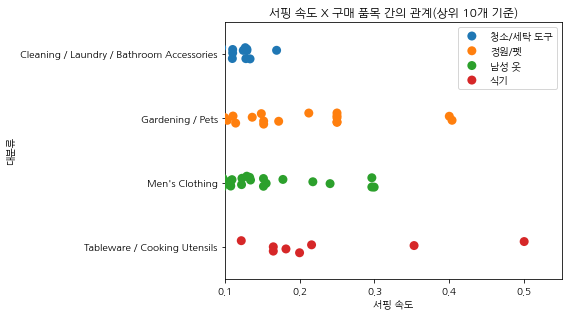

In [303]:
fig, ax = plt.subplots(figsize=(8,4.5))
sns.stripplot(data=test, x='pv_hr', y='clac_nm1', size = 9)
lable =['청소/세탁 도구', '정원/펫', '남성 옷', '식기']

plt.title('서핑 속도 X 구매 품목 간의 관계')
plt.xlim(0.10, 0.55)
plt.legend(lable)
plt.xlabel('서핑 속도'); plt.ylabel('대분류')
plt.tight_layout()

plt.show()

In [323]:
test.columns

Index(['clnt_id_x', 'sess_id', 'hit_seq', 'action_type', 'biz_unit_x',
       'sess_dt', 'hit_tm', 'hit_pss_tm', 'trans_id', 'sech_kwd',
       'tot_pag_view_ct', 'tot_sess_hr_v', 'trfc_src', 'dvc_ctg_nm',
       'cum_act_0', 'cum_act_1', 'cum_act_2', 'cum_act_3', 'cum_act_4',
       'cum_act_5', 'cum_act_6', 'cum_act_7', 'day', 'holiday', 'hour',
       'pv_hr', 'latest_pv_hr_1', 'latest_pv_hr_2', 'latest_pv_hr_3',
       'prefer_dvc_trfc', 'latest_act_hr_1', 'latest_act_hr_2',
       'latest_act_hr_3', 'hum', 'temp', 'pty', 'r06', 'clnt_id_y',
       'trans_seq', 'biz_unit_y', 'pd_c', 'de_dt', 'de_tm', 'buy_am', 'buy_ct',
       'clac_nm1'],
      dtype='object')

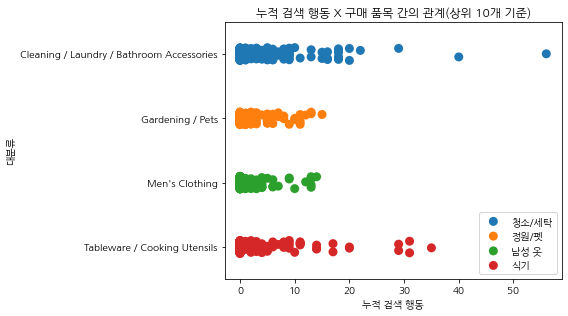

In [339]:
fig, ax = plt.subplots(figsize=(8,4.5))
sns.stripplot(data=test, x='cum_act_0', y='clac_nm1', size = 9)
lable =['청소/세탁', '정원/펫', '남성 옷', '식기']

plt.title('누적 검색 행동 X 구매 품목 간의 관계')
# plt.xlim(16, 21)
plt.legend(lable)
plt.xlabel('누적 검색 행동'); plt.ylabel('대분류')
plt.tight_layout()

plt.show()

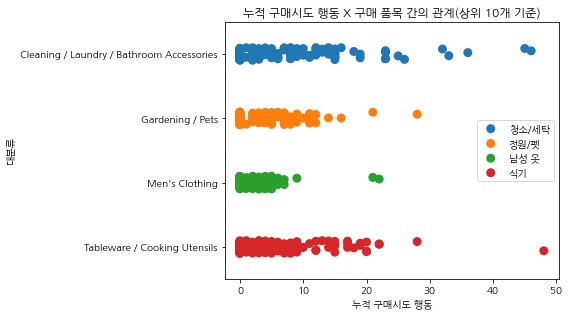

In [340]:
fig, ax = plt.subplots(figsize=(8,4.5))
sns.stripplot(data=test, x='cum_act_5', y='clac_nm1', size = 9)
lable =['청소/세탁', '정원/펫', '남성 옷', '식기']

plt.title('누적 구매시도 행동 X 구매 품목 간의 관계(상위 10개 기준)')
# plt.xlim(16, 21)
plt.legend(lable)
plt.xlabel('누적 구매시도 행동'); plt.ylabel('대분류')
plt.tight_layout()

plt.show()

In [100]:
sample_3.columns

Index(['clnt_id_x', 'sess_id', 'hit_seq', 'action_type', 'biz_unit_x',
       'sess_dt', 'hit_tm', 'hit_pss_tm', 'trans_id', 'sech_kwd',
       'tot_pag_view_ct', 'tot_sess_hr_v', 'trfc_src', 'dvc_ctg_nm',
       'cum_act_0', 'cum_act_1', 'cum_act_2', 'cum_act_3', 'cum_act_4',
       'cum_act_5', 'cum_act_6', 'cum_act_7', 'day', 'holiday', 'hour',
       'pv_hr', 'latest_pv_hr_1', 'latest_pv_hr_2', 'latest_pv_hr_3',
       'prefer_dvc_trfc', 'latest_act_hr_1', 'latest_act_hr_2',
       'latest_act_hr_3', 'hum', 'temp', 'pty', 'r06', 'clnt_id_y',
       'trans_seq', 'biz_unit_y', 'pd_c', 'de_dt', 'de_tm', 'buy_am', 'buy_ct',
       'clac_nm1'],
      dtype='object')

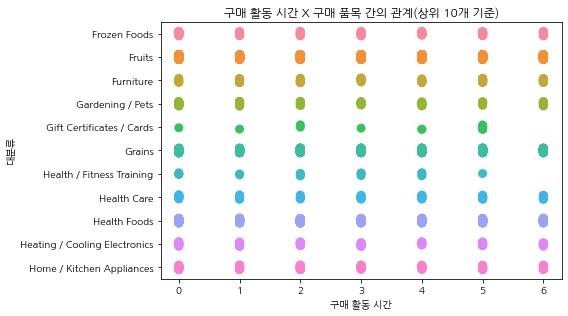

In [247]:
fig, ax = plt.subplots(figsize=(8,4.5))
sns.stripplot(data=sample_3[50000:60000], x='day', y='clac_nm1', size = 9)

plt.title('구매 활동 시간 X 구매 품목 간의 관계(상위 10개 기준)')
# plt.xlim(10, 20)
plt.xlabel('구매 활동 시간'); plt.ylabel('대분류')
plt.tight_layout()

plt.show()

In [346]:
item_add_nm0 = pd.read_csv('./data/item_add_nm0.csv')
item_add_nm0 = item_add_nm0[['pd_c', 'clac_nm2']]

In [347]:
item_add_nm0['pd_c'] = item_add_nm0['pd_c'].astype(np.float).astype(str)

In [348]:
df3_trade = trade.merge(item_add_nm0, how = 'left')
df3_trade.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm2
0,2,42449.0,1,A02,1015.0,20190704,15:34,46430,1,Men's Upper Bodywear / Tops
1,2,62037.0,1,A03,92.0,20190729,23:47,36000,20,Coffee Drinks
2,2,64691.0,1,A03,186.0,20190731,21:25,3790,1,Fish Cakes and Crab Sticks
3,2,64691.0,2,A03,151.0,20190731,21:25,3990,1,Canned Agricultural Foods
4,2,64691.0,3,A03,351.0,20190731,21:25,4690,1,Processed Dairy Products


In [349]:
sample_3 = pd.merge(df2_online, 
                     df3_trade, 
                on='trans_id', how='left')

In [350]:
sample_3 = sample_3[sample_3['clac_nm2'].notna()]

In [351]:
sample_3 = sample_3.sort_values('clac_nm2')

In [ ]:
sample_3['clac_nm2'].value_counts().sort_index()[:10].sum()

In [ ]:
sample_3['clac_nm2'].value_counts().sort_index()[:214].sum()

In [208]:
sample_3['clac_nm2'].value_counts().sort_index()[:215].sum()

85084

In [194]:
sample_3['clac_nm2'].value_counts().sort_index()[125:130]

Hot Snacks               140
Ice Creams               763
Imported Fruits         1986
Imported Porks           227
Improvement Supplies       1
Name: clac_nm2, dtype: int64

In [181]:
sample_3['clac_nm2'].value_counts().sort_index()[:93].sum()

45878

In [182]:
sample_3['clac_nm2'].value_counts().sort_index()[:92].sum()

38078

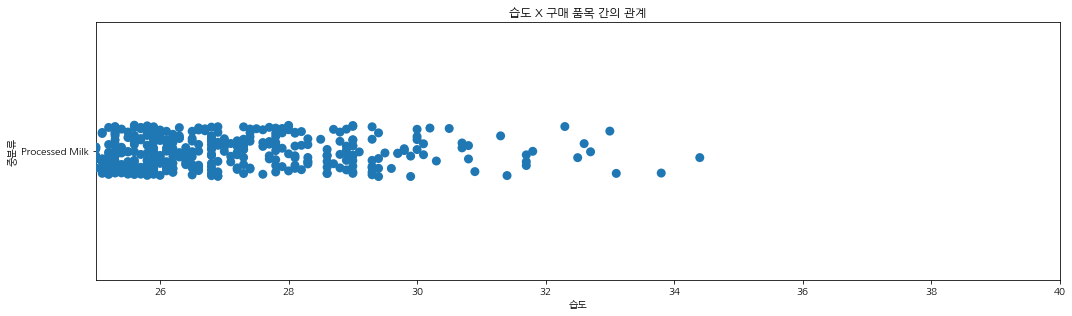

In [210]:
fig, ax = plt.subplots(figsize=(15,4.5))
sns.stripplot(data=sample_3[84327:85084], x='temp', y='clac_nm2', size = 9)

plt.title('습도 X 구매 품목 간의 관계')
plt.xlim(25, 40)
plt.xlabel('습도'); plt.ylabel('중분류')
plt.tight_layout()

plt.show()

In [217]:
sample_3[84327:85084]

SyntaxError: invalid syntax (<ipython-input-217-b6e1e277673d>, line 1)

In [ ]:
sample_3

In [352]:
test = pd.concat([sample_3[54398:55161], sample_3[84327:85084]])

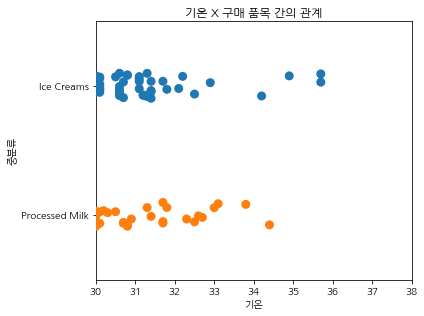

In [359]:
fig, ax = plt.subplots(figsize=(6,4.5))
sns.stripplot(data=test, x='temp', y='clac_nm2', size = 9)

plt.title('기온 X 구매 품목 간의 관계')
plt.xlim(30, 38)
plt.xlabel('기온'); plt.ylabel('중분류')
plt.tight_layout()

plt.show()

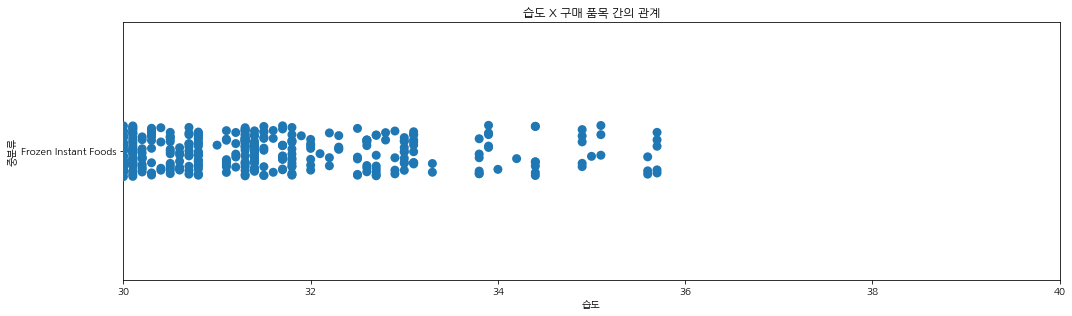

In [189]:
fig, ax = plt.subplots(figsize=(15,4.5))
sns.stripplot(data=sample_3[38078:45878], x='temp', y='clac_nm2', size = 9)

plt.title('습도 X 구매 품목 간의 관계')
plt.xlim(30, 40)
plt.xlabel('습도'); plt.ylabel('중분류')
plt.tight_layout()

plt.show()

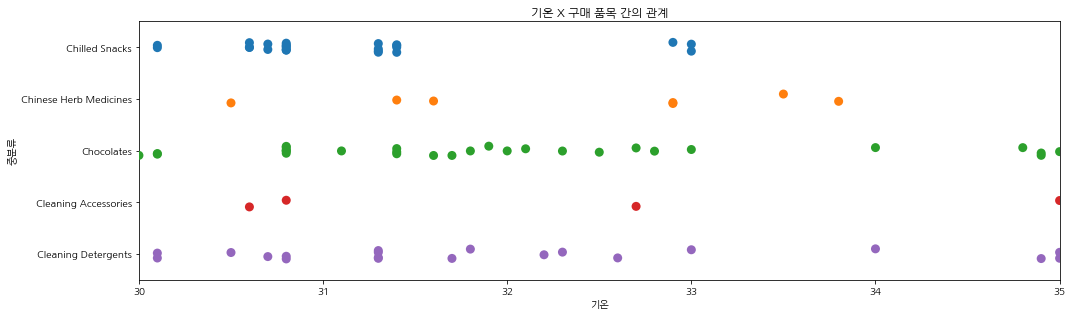

In [170]:
fig, ax = plt.subplots(figsize=(15,4.5))
sns.stripplot(data=sample_3[15869:17387], x='temp', y='clac_nm2', size = 9)

plt.title('기온 X 구매 품목 간의 관계')
plt.xlim(30, 35)
plt.xlabel('기온'); plt.ylabel('중분류')
plt.tight_layout()

plt.show()

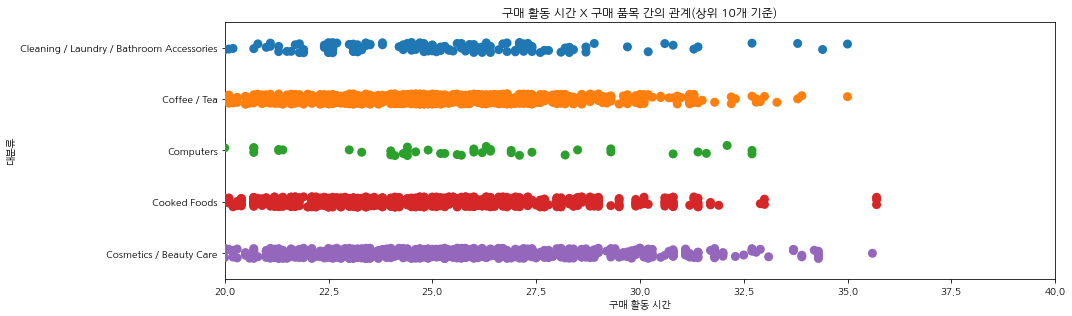

In [147]:
fig, ax = plt.subplots(figsize=(15,4.5))
sns.stripplot(data=sample_3[21861:24772], x='temp', y='clac_nm1', size = 9)

plt.title('구매 활동 시간 X 구매 품목 간의 관계(상위 10개 기준)')
plt.xlim(20, 40)
plt.xlabel('구매 활동 시간'); plt.ylabel('대분류')
plt.tight_layout()

plt.show()

In [142]:
sample_3['clac_nm1'].value_counts().sort_index()[:10].sum()

21861

In [141]:
sample_3['clac_nm1'].value_counts().sort_index()[:15].sum()

24772

In [123]:
sample_3['clac_nm1'].value_counts().sort_index()[:50].sum()

104333

In [131]:
sample_3['clac_nm1'].value_counts().sort_index()[:52].sum()

104439

In [132]:
sample_3['clac_nm1'].value_counts().sort_index()[:53].sum()

105050

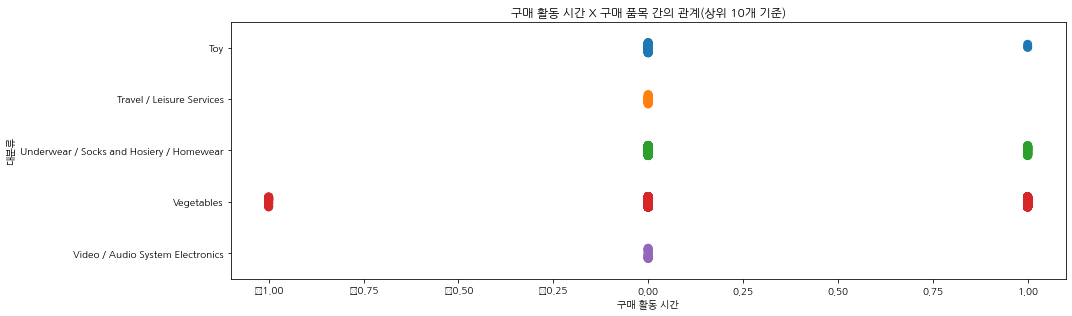

In [128]:
fig, ax = plt.subplots(figsize=(15,4.5))
sns.stripplot(data=sample_3[104333:120347], x='pty', y='clac_nm1', size = 9)

plt.title('구매 활동 시간 X 구매 품목 간의 관계(상위 10개 기준)')
# plt.xlim(10, 20)
plt.xlabel('구매 활동 시간'); plt.ylabel('대분류')
plt.tight_layout()

plt.show()

<AxesSubplot:xlabel='pty', ylabel='count'>

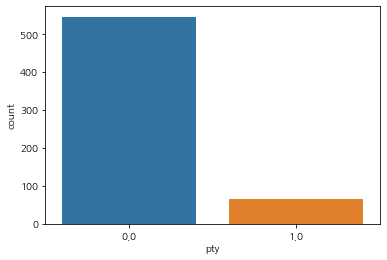

In [134]:
sns.countplot(sample_3[104439:105050]['pty'])

In [ ]:
sns.countplot(sample_3[104439:105050]['pty'])

<br>

### 데이터 처리: `Trade + Item`
- 거래 ID와 Item을 `pd_c` 기준으로 합쳐줍니다. 


In [19]:
df3_trade = trade.merge(item, how = 'left')
df3_trade.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3
0,2,42449.0,1,A02,1015.0,20190704,15:34,46430,1,Men's Clothing,Men's Upper Bodywear / Tops,Men's T-shirts
1,2,62037.0,1,A03,92.0,20190729,23:47,36000,20,Beverages,Coffee Drinks,Coffee Drinks
2,2,64691.0,1,A03,186.0,20190731,21:25,3790,1,Chilled Foods,Fish Cakes and Crab Sticks,Crab Sticks
3,2,64691.0,2,A03,151.0,20190731,21:25,3990,1,Canned / Jarred Foods,Canned Agricultural Foods,Canned Vegetable Foods
4,2,64691.0,3,A03,351.0,20190731,21:25,4690,1,Dairy Products,Processed Dairy Products,Cream and Condensed milk


In [20]:
df3_trade_item = df3_trade[['trans_id', 'clac_nm2']]

<br>

### 데이터 처리: `Online + Customer`
- online 데이터와 고객 데이터를 `clnt_id` 기준으로 합쳐줍니다. 


In [21]:
df3_online_customer = df2_online.merge(customer, how = 'left')
df3_online_customer.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,latest_act_hr_1,latest_act_hr_2,latest_act_hr_3,hum,temp,pty,r06,sech_clac_nm1,clnt_gender,clnt_age
0,1,1,1,0,A01,2019-09-11,16:14,11880,NaN,과일선물세트,...,-1.0,-1.0,-1.0,67.0,22.100000,0.0,0.0,Chilled Foods,NaN,NaN
1,1,1,2,0,A01,2019-09-11,16:15,22432,NaN,과일선물세트 백화점,...,-1.0,-1.0,-1.0,67.0,22.100000,0.0,0.0,NaN,NaN,NaN
2,1,1,3,0,A01,2019-09-11,16:15,36140,NaN,과일바구니,...,-1.0,-1.0,-1.0,67.0,22.100000,0.0,0.0,Living / Rental Services,NaN,NaN
3,1,2,1,0,A01,2019-09-22,14:09,41584,NaN,초등가을잠바,...,16.0,-1.0,-1.0,58.0,18.200001,0.0,0.0,NaN,NaN,NaN
4,1,2,2,0,A01,2019-09-22,14:10,56113,NaN,초등가을점퍼,...,16.0,-1.0,-1.0,58.0,18.200001,0.0,0.0,NaN,NaN,NaN


<br>

### 데이터 처리: `Online + Trade`
- merge를 하기 전 trans_id의 중복을 제거하기 위함입니다. 


In [22]:
df3_merge = pd.merge(df3_online_customer, 
                     df3_trade_item, 
                on='trans_id', how='left')

In [23]:
print(df3_merge.shape)
df3_merge.head()

(3299190, 41)


,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,latest_act_hr_2,latest_act_hr_3,hum,temp,pty,r06,sech_clac_nm1,clnt_gender,clnt_age,clac_nm2
0,1,1,1,0,A01,2019-09-11,16:14,11880,NaN,과일선물세트,...,-1.0,-1.0,67.0,22.100000,0.0,0.0,Chilled Foods,NaN,NaN,NaN
1,1,1,2,0,A01,2019-09-11,16:15,22432,NaN,과일선물세트 백화점,...,-1.0,-1.0,67.0,22.100000,0.0,0.0,NaN,NaN,NaN,NaN
2,1,1,3,0,A01,2019-09-11,16:15,36140,NaN,과일바구니,...,-1.0,-1.0,67.0,22.100000,0.0,0.0,Living / Rental Services,NaN,NaN,NaN
3,1,2,1,0,A01,2019-09-22,14:09,41584,NaN,초등가을잠바,...,-1.0,-1.0,58.0,18.200001,0.0,0.0,NaN,NaN,NaN,NaN
4,1,2,2,0,A01,2019-09-22,14:10,56113,NaN,초등가을점퍼,...,-1.0,-1.0,58.0,18.200001,0.0,0.0,NaN,NaN,NaN,NaN


In [24]:
df3_merge.to_csv('./data/df3_merge.csv',index=False)

In [2]:
df3_merge = pd.read_csv('./data/df3_merge.csv')

In [8]:
df3_merge

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,latest_act_hr_1,latest_act_hr_2,latest_act_hr_3,hum,temp,pty,r06,clnt_gender,clnt_age,clac_nm2
0,1,1,1,0,A01,2019-09-11,16:14,11880,NaN,과일선물세트,...,-1.0,-1.0,-1.0,67.0,22.100000,0.0,0.0,NaN,NaN,NaN
1,1,1,2,0,A01,2019-09-11,16:15,22432,NaN,과일선물세트 백화점,...,-1.0,-1.0,-1.0,67.0,22.100000,0.0,0.0,NaN,NaN,NaN
2,1,1,3,0,A01,2019-09-11,16:15,36140,NaN,과일바구니,...,-1.0,-1.0,-1.0,67.0,22.100000,0.0,0.0,NaN,NaN,NaN
3,1,2,1,0,A01,2019-09-22,14:09,41584,NaN,초등가을잠바,...,16.0,-1.0,-1.0,58.0,18.200001,0.0,0.0,NaN,NaN,NaN
4,1,2,2,0,A01,2019-09-22,14:10,56113,NaN,초등가을점퍼,...,16.0,-1.0,-1.0,58.0,18.200001,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299185,72428,3,3,0,A01,2019-09-14,21:50,839771,NaN,페레가모가방,...,10.0,10.0,-1.0,92.0,19.600000,0.0,0.0,NaN,NaN,NaN
3299186,72428,4,1,0,A01,2019-09-14,23:42,243555,NaN,펜디가방,...,21.0,10.0,10.0,66.0,23.200001,0.0,0.0,NaN,NaN,NaN
3299187,72428,5,1,0,A01,2019-09-18,06:37,12568,NaN,라인에디션블라우스,...,23.0,21.0,10.0,29.0,24.600000,0.0,0.0,NaN,NaN,NaN
3299188,72429,1,1,1,A03,2019-09-19,22:09,839064,NaN,NaN,...,-1.0,-1.0,-1.0,59.0,17.299999,0.0,0.0,NaN,NaN,NaN


In [ ]:
df5_merge = df3_merge.merge(test, how='left')

In [ ]:
df5_merge

In [3]:
df3_merge = pd.read_csv('./data/df3_merge.csv')

In [4]:
total = pd.read_csv('./data/total_label.csv')

In [28]:
df_merge_label = pd.concat([df3_merge,total['label']], axis=1)

In [30]:
df_merge_label.drop('clac_nm2', axis=1, inplace=True)

In [31]:
df_merge_label.to_csv('./data/df_merge_label.csv', index=False)